# Gaussian process regression: Hand-coding for a simple case

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import GPRegression as gp

## 0. Load the data

In [2]:
data_train = pd.read_csv("Simple_train.csv")
data_test = pd.read_csv("Simple_test.csv")

X_test = data_test['X'].values.reshape(-1 , 1)
X_train = data_train['X'].values.reshape(-1 , 1)
Y_train = data_train['Y'].values.reshape(-1 , 1)

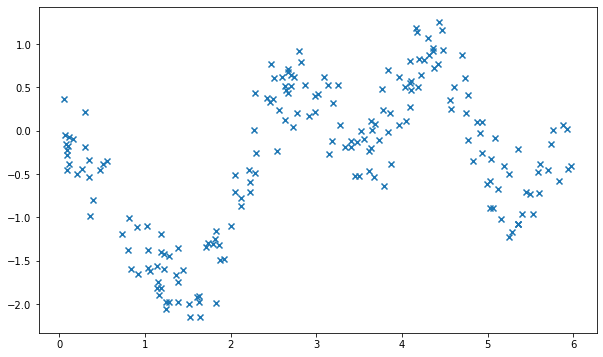

In [3]:
plt.figure(figsize=(10 , 6))
plt.scatter(data_train['X'] , data_train['Y'] , marker = 'x')

## 1. Full Gaussian Process Regression

Pour tout point test $x^*$ on a la loi a posteriori:   

\begin{equation*}
p(y^* | Y) \, \sim \,\mathcal{N}(m_y(x^*) , k_y(x^* , x^*) + \sigma^2)
\end{equation*}   

Les fonctions $m_y$ et $k_y$ du GP a posteriori sont définies par:   

\begin{align*}
\begin{cases}
&m_y(x) = K_{xn} (\sigma^2 I + K_{nn})^{-1} Y \\\\
&k_y(x , x') = k(x , x') - K_{xn} (\sigma^2 I + K_{nn})^{-1} K_{nx'}
\end{cases}
\end{align*}   

Où $K_{nn} = (k(x_i , x_j))_{1 \leq i , j \leq n}$ ,  $K_{xn} = (k(x , x_i))_i$ et $k$ le noyau associé au GP a priori (paramétré par $\theta$).   
   
Pour optimiser les hyperparamètres on utilise la log-vraisemblance marginal associée aux observations $Y$:   

\begin{equation*}
log(p(Y | X , \theta)) = -\frac{1}{2}Y^{T}\left(\sigma^{2}I_n + K_{nn}\right)^{-1}Y - \frac{1}{2}log\left(|\sigma^{2}I_n + K_{nn}| \right) - \frac{1}{2}log(2\pi)
\end{equation*}   


In [4]:
GPR_Full = gp.GPRegression(X_train , Y_train , method = "Full" , kernel = "Gaussian")

In [5]:
PM , std = gp.Predict(GPR_Full , X_test , theta0 = np.array([1 , 1]) , sigma0 = 0.5)

         Current function value: 99.500131
         Iterations: 10
         Function evaluations: 129
         Gradient evaluations: 32


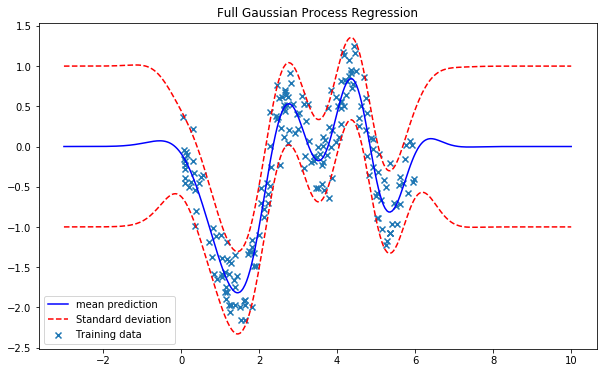

In [6]:
gp.plot_regression(GPR_Full , X_test , PM , std )

## 2. Sparse Gaussian Process Regression   

On considère d'abord $m$ "induced point" $\tilde{X}$ et on définit, au préalable, les matrices $\Lambda$ et $Q_m$: 

\begin{align*}
\begin{cases}
&\Lambda = diag \left( K_{nn} -K_{nm}K_{m}^{-1}K_{mn} \right) \\
&Q_{m} = K_m + K_{mn} \left( \Lambda + \sigma^{2} I \right)^{-1} K_{nm}
\end{cases}
\end{align*}   

Où $K_{m} = (k(\tilde{x}_i , \tilde{x}_j))_{1 \leq i , j \leq m}$ ,  $K_{mn} = (k(\tilde{x}_i , x_j))_{1 \leq i \leq m \, , \, 1\leq j \leq n}$ et $k$ le noyau associé au GP a priori (paramétré par $\theta$).      

Pour tout point test $x^*$ on a alors la loi a posteriori:   

\begin{equation*}
p(y^* | Y) \, \sim \,\mathcal{N}(\tilde{m}_y(x^*) , \tilde{k}_y(x^* , x^*) + \sigma^2)
\end{equation*} 

Les fonctions $m_y$ et $k_y$ du GP a posteriori sont définies par:   

\begin{align*}
\begin{cases}
&\tilde{m}_y(x) = K_{xn}Q_{m}^{-1}K_{mn} \left( \Lambda + \sigma^{2} I \right)^{-1} Y \\\\
&\tilde{k}_y(x , x') = k(x , x') - K_{xn} \left( K_{m}^{-1} - Q_{m}^{-1} \right) K_{nx'}
\end{cases}
\end{align*} 

**Remarque:** Les formules ci-dessus sont écrites pour le cas "SPGP". Pour retrouver les formules du cas "PP", il suffit d'enlever la matrice $\Lambda$.   

Pour optimiser les hyperparamètres on utilise une approximation de la log-vraisemblance marginal associée aux observations $Y$:   

\begin{equation*}
log(p(Y | X , \theta)) = -\frac{1}{2}Y^{T}\left(\sigma^{2}I_n + Q_{nn}\right)^{-1}Y - \frac{1}{2}log\left(|\sigma^{2}I_n + Q_{nn}| \right) - \frac{1}{2}log(2\pi)
\end{equation*}

$Q_{nn}$ correspond à la version approchée de la matrice de covariance en utilisant les m "induced points":   

\begin{align*}
&Q_{nn} = K_{nm}K_{mm}^{-1}K_{mn} \qquad \text{(PP)} \\
&Q_{nn} = \Lambda +  K_{nm}K_{mm}^{-1}K_{mn} \qquad \text{(SPGP)}
\end{align*}

In [7]:
GPR_PP = gp.GPRegression(X_train , Y_train , method = "PP" , kernel = "Gaussian")

In [8]:
PM , std , X_induced0 = gp.Predict(GPR_PP , X_test , theta0 = np.array([1 , 1]) , sigma0 = 0.5 , m=10)

         Current function value: 95.791774
         Iterations: 35
         Function evaluations: 1579
         Gradient evaluations: 112


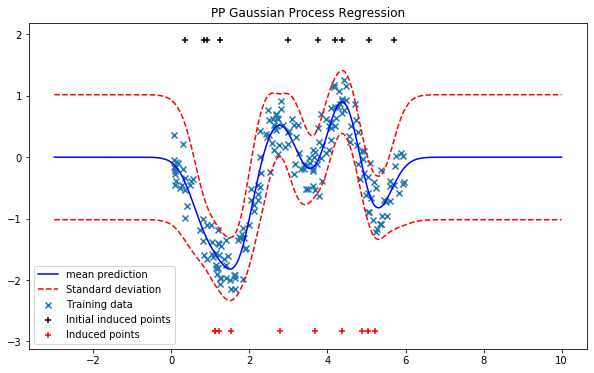

In [9]:
gp.plot_regression(GPR_PP , X_test , PM , std , X_induced0)

In [10]:
GPR_SPGP = gp.GPRegression(X_train , Y_train , method = "SPGP" , kernel = "Gaussian")

In [11]:
PM , std , X_induced0 = gp.Predict(GPR_SPGP , X_test , theta0 = np.array([1 , 1]) , sigma0 = 0.5 , m=10)

         Current function value: 99.599431
         Iterations: 35
         Function evaluations: 1009
         Gradient evaluations: 72


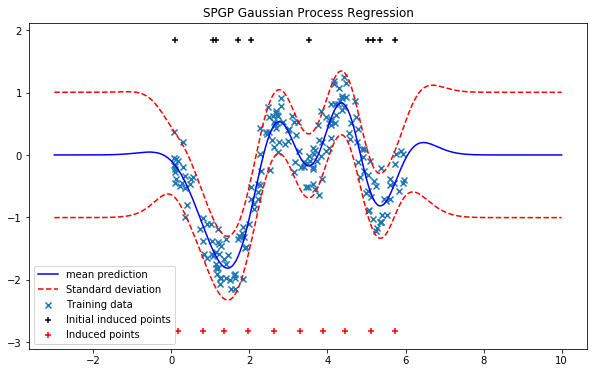

In [12]:
gp.plot_regression(GPR_SPGP , X_test , PM , std , X_induced0)